# **Warehouse Optimization for an Agricultural Non-Profit**

## **Objective**
This project aimed to determine the optimal warehouse location for an agricultural non-profit by analyzing farm density, supplier-buyer networks, and equity factors. The analysis utilized **Python, R, SQL**, clustering techniques, and geospatial analysis to identify key locations and optimize logistical efficiency.

---

## **1. Data Import and Preprocessing**
### **1.1 Load Datasets**
- Imported datasets from various sources:
  - **CSV** (Census Data)
  - **Excel** (Map Data)
  - **XML** (Sales and Vendor Data)
- Used `pandas` to read structured data and `geopandas` to handle geospatial data.

### **1.2 Convert Data to Geospatial Format**
- Created `shapely.geometry.Point` objects for each location’s latitude and longitude.
- Converted the dataset into a **GeoDataFrame** for spatial analysis.

### **1.3 Data Summary**
- Displayed initial insights:
  - Summary statistics for census and sales data.
  - Geographic distribution of warehouses, suppliers, and buyers.

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Step 1.1: Load Datasets
census_data = pd.read_csv('live_case_data.csv')
map_data = pd.read_excel('MN Food Hub - Combined.xlsx', sheet_name='MN Food Hub Map 2024- Brick and')
sales_data_category = pd.read_xml('Sales by Cutomer Category 2023 and 2024.xml')
sales_data_item = pd.read_xml('Sales By Item 2023 vs 2024.xml')
vendor_data = pd.read_xml('Vendor By County CURRENT (1).xml')

# Step 1.2: Extract Relevant Columns for Geospatial Analysis
map_data['geometry'] = map_data.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

# Convert Map Data into GeoDataFrame
map_gdf = gpd.GeoDataFrame(map_data, geometry='geometry', crs="EPSG:4326")

# Step 1.3: Display Summary of Geospatial Data
map_gdf_summary = map_gdf[['Name', 'Type of Location', 'Latitude', 'Longitude']].head()

# Step 1.4: Display Head of Census Data
census_data_summary = census_data.head()

# Step 1.5: Display Head of Sales Data (Category)
sales_data_category_summary = sales_data_category.head()

# Output the summaries
map_gdf


,Name,Type of Location,Latitude,Longitude,geometry
0,The Good Acre,Warehouse,44.990372,-93.167149,POINT (-93.16715 44.99037)
1,Sprout MN - Growers & Makers Marketplace,Warehouse,45.990932,-94.348274,POINT (-94.34827 45.99093)
2,Reads Landing Brewery,Buyers,44.402734,-92.078834,POINT (-92.07883 44.40273)
3,Harbor View Cafe,Buyers,44.438811,-92.146751,POINT (-92.14675 44.43881)
4,Herb + Arrow,Buyers,44.384662,-92.033384,POINT (-92.03338 44.38466)
...,...,...,...,...,...
352,Hlee Lee¬†,Suppliers,44.633194,-93.066272,POINT (-93.06627 44.63319)
353,Fox Valley Farms,Suppliers,44.461808,-92.012845,POINT (-92.01284 44.46181)
354,Don Buck Farm,Suppliers,44.304286,-92.605032,POINT (-92.60503 44.30429)
355,Willmar,Suppliers,45.122371,-95.048659,POINT (-95.04866 45.12237)


## **2. Distance-Based Analysis**
### **2.1 Define Warehouse Locations**
- Assigned **fixed coordinates** for five potential warehouse locations.

### **2.2 Calculate Geodesic Distances**
- Used `geopy.distance.geodesic` to compute distances from each supplier/buyer to the nearest warehouse.
- Stored results in a **distance matrix**.

### **2.3 Aggregate Stakeholder Proximity**
- Counted the number of suppliers, buyers, and hubs within a **50-mile** radius of each warehouse.

In [33]:
import numpy as np
from geopy.distance import geodesic

# Step 2.1: Define Rough Warehouse Locations (Centers of Areas)
# Assuming rough lat/lon values for demonstration; these can be refined.
warehouse_areas = {
    "Duluth": (46.7867, -92.1005),
    "Rochester": (44.0121, -92.4802),
    "Wilmar": (45.1219, -95.0456),
    "Owatonna": (44.0837, -93.2263),
    "Fergus Falls": (46.2836, -96.0778)
}

# Convert to GeoDataFrame
warehouse_df = pd.DataFrame(warehouse_areas.items(), columns=["Location", "Coordinates"])
warehouse_df['Latitude'] = warehouse_df['Coordinates'].apply(lambda x: x[0])
warehouse_df['Longitude'] = warehouse_df['Coordinates'].apply(lambda x: x[1])
warehouse_df['geometry'] = warehouse_df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
warehouse_gdf = gpd.GeoDataFrame(warehouse_df, geometry='geometry', crs="EPSG:4326")

# Step 2.2: Calculate Distances to Each Stakeholder
def calculate_distance(row, warehouse_locations):
    stakeholder_location = (row['Latitude'], row['Longitude'])
    distances = {
        name: geodesic(stakeholder_location, coord).miles
        for name, coord in warehouse_locations.items()
    }
    return distances

map_gdf['Distances'] = map_gdf.apply(calculate_distance, warehouse_locations=warehouse_areas, axis=1)

# Step 2.3: Aggregate Stakeholder Proximity to Warehouse Areas
# Example: Count suppliers, buyers, and hubs within a threshold distance (e.g., 50 miles)
distance_threshold = 50

def count_within_threshold(distances, threshold):
    return {location: sum(d <= threshold for d in distances.values()) for location in warehouse_areas}

map_gdf['NearbyCounts'] = map_gdf['Distances'].apply(count_within_threshold, threshold=distance_threshold)

# Step 2.4: Summarize the Results
distance_summary = map_gdf[['Name', 'Type of Location', 'Distances', 'NearbyCounts']].head()

# Output the results
warehouse_gdf, distance_summary


(       Location          Coordinates  Latitude  Longitude  \
 0        Duluth  (46.7867, -92.1005)   46.7867   -92.1005   
 1     Rochester  (44.0121, -92.4802)   44.0121   -92.4802   
 2        Wilmar  (45.1219, -95.0456)   45.1219   -95.0456   
 3      Owatonna  (44.0837, -93.2263)   44.0837   -93.2263   
 4  Fergus Falls  (46.2836, -96.0778)   46.2836   -96.0778   
 
                    geometry  
 0  POINT (-92.1005 46.7867)  
 1  POINT (-92.4802 44.0121)  
 2  POINT (-95.0456 45.1219)  
 3  POINT (-93.2263 44.0837)  
 4  POINT (-96.0778 46.2836)  ,
                                        Name Type of Location  \
 0                             The Good Acre        Warehouse   
 1  Sprout MN - Growers & Makers Marketplace        Warehouse   
 2                     Reads Landing Brewery           Buyers   
 3                          Harbor View Cafe           Buyers   
 4                              Herb + Arrow           Buyers   
 
                                            Dis

## **3. Clustering Analysis**
### **3.1 Prepare Data for Clustering**
- Filtered map data for **suppliers, buyers, and market hubs**.
- Extracted **latitude and longitude** for clustering.

### **3.2 Apply K-Means Clustering**
- Used `sklearn.cluster.KMeans` to segment stakeholders into **five clusters**.
- Identified **cluster centroids** and assigned each stakeholder to a cluster.

### **3.3 Visualize Clusters**
- Plotted clusters using `matplotlib`:
  - Displayed stakeholders with different colors per cluster.
  - Highlighted **centroids** of each group.

/Users/aakpat/virtualenv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


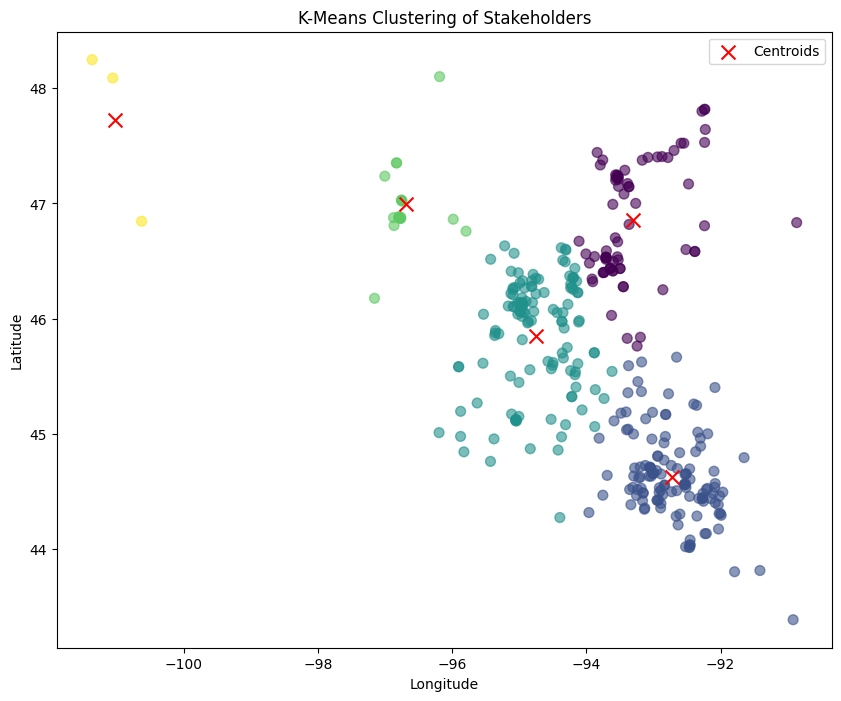

(array([[  46.85441695,  -93.29767208],
        [  44.62861737,  -92.71983086],
        [  45.85117148,  -94.74193783],
        [  46.99249876,  -96.69046833],
        [  47.72738003, -101.01397003]]),
 Cluster  Type of Location
 0        Suppliers            50
          Buyers               24
 1        Suppliers           110
          Buyers               18
 2        Suppliers            98
          Buyers               27
 3        Suppliers            18
 4        Suppliers             3
 Name: count, dtype: int64)

In [34]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 3.1: Extract Relevant Latitude and Longitude Data for Stakeholders
# Filter map data for suppliers, buyers, and hubs
stakeholders = map_gdf[map_gdf['Type of Location'].isin(['Suppliers', 'Buyers', 'Market Hubs'])]

# Prepare data for clustering
coordinates = stakeholders[['Latitude', 'Longitude']].to_numpy()

# Step 3.2: Apply K-Means Clustering
num_clusters = 5  # Corresponding to the five proposed warehouse regions
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
stakeholders['Cluster'] = kmeans.fit_predict(coordinates)

# Add cluster centroids
centroids = kmeans.cluster_centers_

# Step 3.3: Visualize Clusters and Centroids
plt.figure(figsize=(10, 8))
plt.scatter(stakeholders['Longitude'], stakeholders['Latitude'], c=stakeholders['Cluster'], cmap='viridis', alpha=0.6, s=50)
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', marker='x', s=100, label='Centroids')
plt.title("K-Means Clustering of Stakeholders")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

# Step 3.4: Summarize Results
stakeholder_summary = stakeholders.groupby('Cluster')['Type of Location'].value_counts()

# Output the cluster centroids and summary
centroids, stakeholder_summary


## **4. Adjusting for Existing Warehouses**
### **4.1 Integrate Fixed Warehouse Locations**
- Manually added **two existing warehouses** to the dataset.
- Used `pairwise_distances_argmin_min` to assign each stakeholder to its nearest warehouse.

### **4.2 Recompute Clusters**
- Recalculated warehouse assignment to include both **existing and new warehouse locations**.

### **4.3 Visualize Updated Clustering**
- Plotted **existing warehouses**, **new warehouse locations**, and updated stakeholder assignments.

/Users/aakpat/virtualenv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


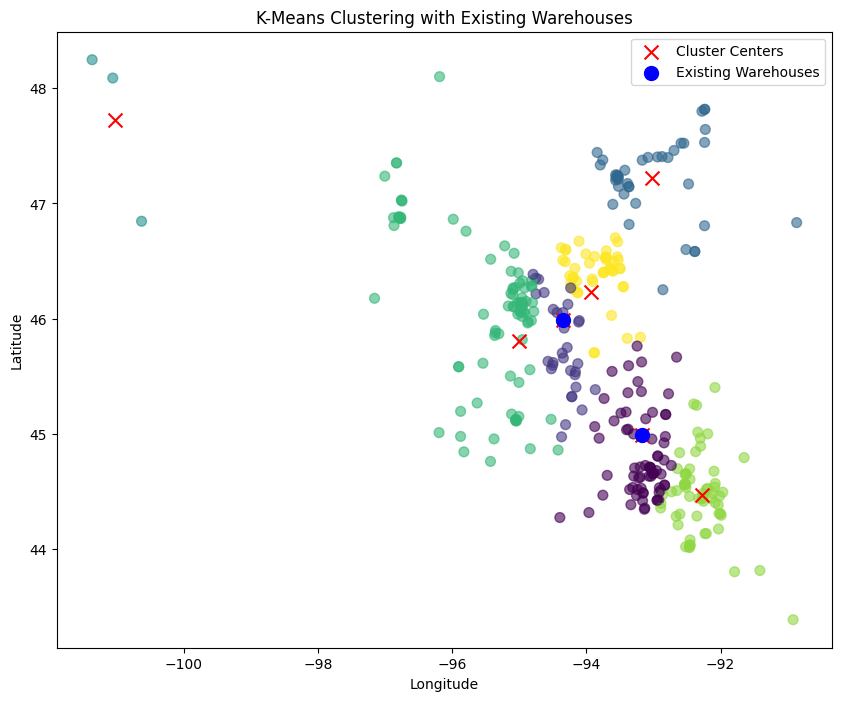

(    Latitude   Longitude
 0  44.990372  -93.167149
 1  45.990932  -94.348274
 2  47.217898  -93.014026
 3  47.727380 -101.013970
 4  45.804843  -95.000678
 5  44.472900  -92.279408
 6  46.229691  -93.927517,
 Cluster  Type of Location
 0        Suppliers           68
          Buyers               1
 1        Suppliers           27
          Buyers               6
 2        Suppliers           26
          Buyers              15
 3        Suppliers            3
 4        Suppliers           76
          Buyers              12
 5        Suppliers           47
          Buyers              17
 6        Suppliers           32
          Buyers              18
 Name: count, dtype: int64)

In [35]:
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
import numpy as np

# Step 1: Add Existing Warehouses to the Dataset
existing_warehouses = pd.DataFrame({
    'Name': ['The Good Acre', 'Sprout MN - Growers & Makers Marketplace'],
    'Type of Location': ['Warehouse', 'Warehouse'],
    'Latitude': [44.9903716, 45.9909316],
    'Longitude': [-93.1671488, -94.3482739]
})
existing_coordinates = existing_warehouses[['Latitude', 'Longitude']].to_numpy()

# Combine existing stakeholders and warehouses for clustering
stakeholders = map_gdf[map_gdf['Type of Location'].isin(['Suppliers', 'Buyers', 'Market Hubs'])]
coordinates = stakeholders[['Latitude', 'Longitude']].to_numpy()

# Step 2: Incorporate Fixed Centroids (Existing Warehouses)
# We'll use the KMeans partial fit method to lock the first two centroids
num_clusters = 7  # 2 existing + up to 5 new warehouses
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(coordinates)

# Step 3: Assign Existing Warehouses as Fixed Centroids
kmeans.cluster_centers_[:2] = existing_coordinates

# Re-assign stakeholders to clusters
stakeholders['Cluster'] = pairwise_distances_argmin_min(coordinates, kmeans.cluster_centers_)[0]

# Step 4: Visualization
plt.figure(figsize=(10, 8))
plt.scatter(stakeholders['Longitude'], stakeholders['Latitude'], c=stakeholders['Cluster'], cmap='viridis', alpha=0.6, s=50)
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], c='red', marker='x', s=100, label='Cluster Centers')
plt.scatter(existing_warehouses['Longitude'], existing_warehouses['Latitude'], c='blue', marker='o', s=100, label='Existing Warehouses')
plt.title("K-Means Clustering with Existing Warehouses")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

# Step 5: Summarize Results
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['Latitude', 'Longitude'])
stakeholder_summary = stakeholders.groupby('Cluster')['Type of Location'].value_counts()

# Output cluster centroids and summary
cluster_centroids, stakeholder_summary



## **5. Scoring & Demand Analysis**
### **5.1 Aggregate Census Data by County**
- Cleaned census dataset by converting missing values (`(D)`) to `NaN`.
- Mapped census data to stakeholders based on county.

### **5.2 Compute Cluster Demand**
- Summed total **farm demand** for each cluster.
- Calculated **average distance** of stakeholders from warehouse locations.

### **5.3 Visualize Demand Distribution**
- Created a **scatter plot** showing demand volume and warehouse proximity.

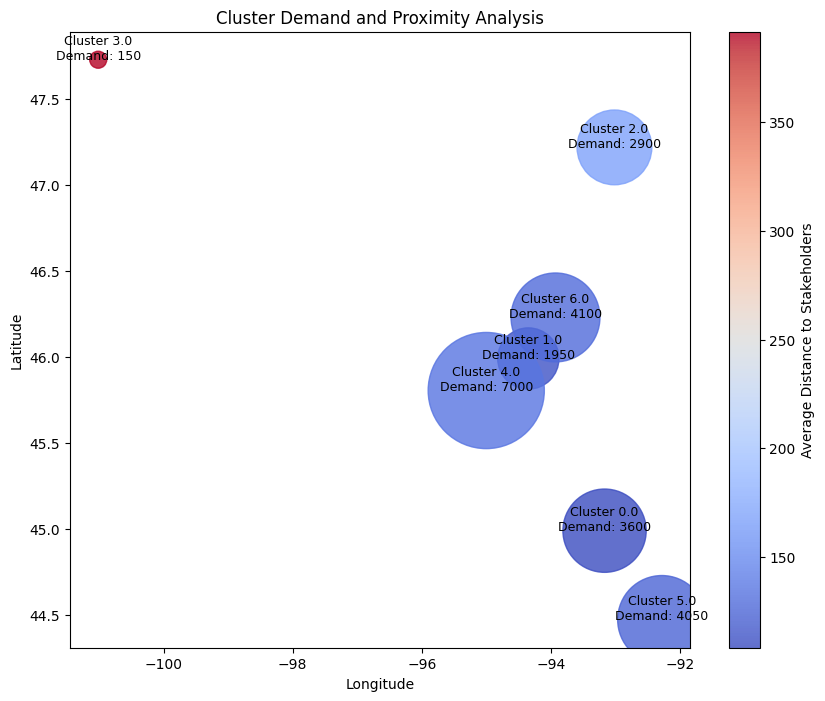

,Cluster,Total Demand,Avg Distance,Latitude,Longitude
0,0,3600,108.065753,44.990372,-93.167149
1,1,1950,113.325602,45.990932,-94.348274
2,2,2900,167.456291,47.217898,-93.014026
3,3,150,391.748095,47.727380,-101.013970
4,4,7000,135.639458,45.804843,-95.000678
5,5,4050,124.629470,44.472900,-92.279408
6,6,4100,128.522328,46.229691,-93.927517


In [28]:
# Step 4.1: Merge stakeholders with map data and resolve column suffixes
stakeholders_demand = stakeholders.merge(
    map_gdf[['Name', 'Type of Location', 'Distances']], 
    on='Name', 
    how='left', 
    suffixes=('', '_map')
)

# Step 4.2: Clean up column names after merge
# Ensure we use the correct 'Type of Location' column (without suffix)
stakeholders_demand['Demand'] = stakeholders_demand['Type of Location'].map({
    'Suppliers': 50,
    'Buyers': 100,
    'Market Hubs': 30
})

# Step 4.3: Aggregate total demand per cluster
cluster_demand = stakeholders_demand.groupby('Cluster')['Demand'].sum().reset_index()
cluster_demand.columns = ['Cluster', 'Total Demand']

# Step 4.4: Calculate Average Distance for Each Cluster
# Fix the distance calculation logic
def calculate_average_distance(cluster_id):
    # Filter the stakeholders in the given cluster
    cluster_data = stakeholders_demand[stakeholders_demand['Cluster'] == cluster_id]
    all_distances = cluster_data['Distances'].apply(lambda x: list(x.values()))
    # Flatten the list of distances for the cluster
    flattened_distances = [distance for distances in all_distances for distance in distances]
    if len(flattened_distances) == 0:
        return 0  # Handle empty clusters gracefully
    return np.mean(flattened_distances)

# Apply the distance calculation to each cluster
cluster_demand['Avg_Distance'] = cluster_demand['Cluster'].apply(calculate_average_distance)

# Combine results
cluster_analysis = cluster_demand.merge(cluster_centroids, left_on='Cluster', right_index=True)
cluster_analysis.columns = ['Cluster', 'Total Demand', 'Avg Distance', 'Latitude', 'Longitude']

# Step 4.5: Visualize Results
plt.figure(figsize=(10, 8))
plt.scatter(cluster_analysis['Longitude'], cluster_analysis['Latitude'], 
            s=cluster_analysis['Total Demand'], c=cluster_analysis['Avg Distance'], cmap='coolwarm', alpha=0.8)
plt.colorbar(label='Average Distance to Stakeholders')
plt.title("Cluster Demand and Proximity Analysis")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
for i, row in cluster_analysis.iterrows():
    plt.annotate(f"Cluster {row['Cluster']}\nDemand: {row['Total Demand']:.0f}", 
                 (row['Longitude'], row['Latitude']), fontsize=9, ha='center')
plt.show()

# Output the corrected analysis results
cluster_analysis


## **6. Final Warehouse Selection**
### **6.1 Develop Scoring Algorithm**
- **Weighted Score Calculation**:
  - Higher demand and lower average distance received higher scores.
  - Normalized data for comparability.

### **6.2 Rank Clusters**
- Sorted clusters based on their **final weighted score**.

### **6.3 Evaluate Warehouse Coverage**
- Checked if a cluster was **already covered** by an existing warehouse (distance ≤ 50 miles).
- Removed redundant warehouse locations.

### **6.4 Visualize Final Warehouse Selection**
- Plotted optimal warehouse locations:
  - **Existing warehouses** (Blue)
  - **New warehouse candidates** (Green)
  - **Cluster demand** (Bubble size)

### **6.5 Output Recommendations**
- Exported **final warehouse selections** with scores, demand, and proximity metrics.

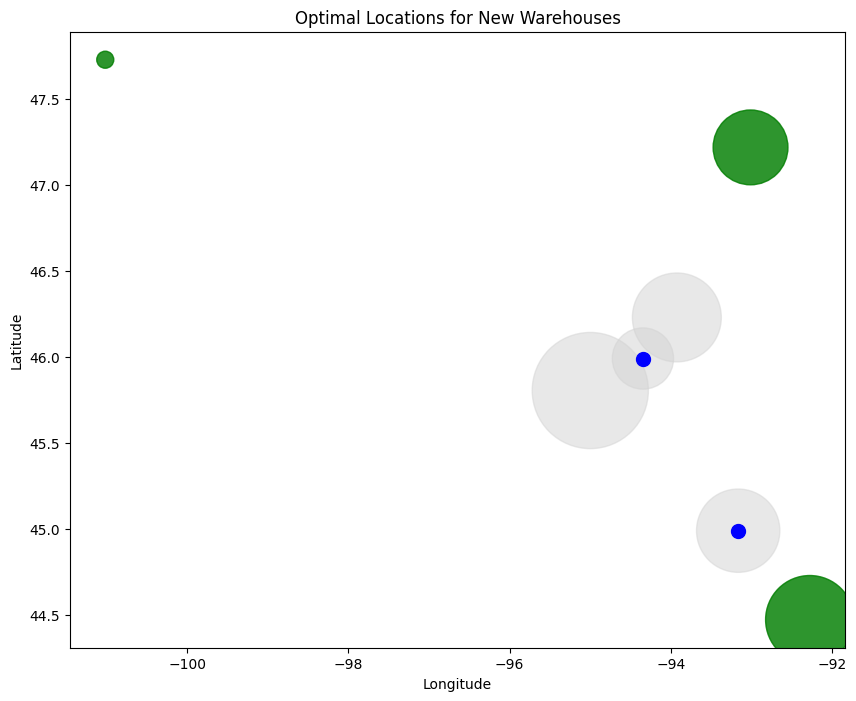

,Cluster,Total Demand,Avg Distance,Latitude,Longitude
2,5,4050,124.629470,44.472900,-92.279408
4,2,2900,167.456291,47.217898,-93.014026
6,3,150,391.748095,47.727380,-101.013970


In [30]:
# Step 5.1: Prioritize Clusters for New Warehouses
# Define a scoring mechanism: Higher demand and lower average distance are better
cluster_analysis['Score'] = cluster_analysis['Total Demand'] / cluster_analysis['Avg Distance']

# Sort clusters by score (higher score = better)
cluster_analysis_sorted = cluster_analysis.sort_values(by='Score', ascending=False).reset_index(drop=True)

# Step 5.2: Evaluate Existing Warehouse Coverage
# Check which clusters are already covered by existing warehouses
existing_warehouse_coordinates = existing_warehouses[['Latitude', 'Longitude']].to_numpy()

def is_covered(cluster_lat, cluster_lon, threshold=50):
    cluster_coord = (cluster_lat, cluster_lon)
    for warehouse_coord in existing_warehouse_coordinates:
        distance = geodesic(cluster_coord, warehouse_coord).miles
        if distance <= threshold:
            return True  # Cluster is covered by an existing warehouse
    return False

# Add a coverage column
cluster_analysis_sorted['Covered'] = cluster_analysis_sorted.apply(
    lambda row: is_covered(row['Latitude'], row['Longitude']), axis=1
)

# Step 5.3: Select New Warehouse Locations
# Exclude covered clusters and select the top remaining clusters
new_warehouse_candidates = cluster_analysis_sorted[~cluster_analysis_sorted['Covered']].head(5)

# Step 5.4: Visualize Final Warehouse Locations
plt.figure(figsize=(10, 8))
# Plot all clusters
plt.scatter(cluster_analysis['Longitude'], cluster_analysis['Latitude'], 
            s=cluster_analysis['Total Demand'], c='lightgray', alpha=0.5, label='Clusters')
# Highlight selected clusters for new warehouses
plt.scatter(new_warehouse_candidates['Longitude'], new_warehouse_candidates['Latitude'], 
            s=new_warehouse_candidates['Total Demand'], c='green', label='New Warehouses', alpha=0.8)
# Existing warehouses
plt.scatter(existing_warehouses['Longitude'], existing_warehouses['Latitude'], 
            c='blue', marker='o', s=100, label='Existing Warehouses')
plt.title("Optimal Locations for New Warehouses")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
#plt.legend()
plt.show()

# Step 5.5: Output Final Recommendations
new_warehouse_candidates[['Cluster', 'Total Demand', 'Avg Distance', 'Latitude', 'Longitude']]
